In [1]:

DATASET_PATH = 'dataset_sorted'

### 2. Import bibliotek
Zestaw narzędzi do przetwarzania obrazu (OpenCV, Scikit-image), obliczeń numerycznych (NumPy), wizualizacji (Matplotlib) oraz uczenia maszynowego (Scikit-learn). Importujemy tu również klasyfikatory KNN i MLP (Perceptron) oraz narzędzia do balansowania danych (SMOTE).

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import distance
import random

# Narzędzia do analizy obrazu i ML
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### 3. Stałe i Bank Filtrów Gabora
Definiujemy rozmiar obrazów (128x128). Tworzymy również **Bank Filtrów Gabora**. Filtry te działają podobnie do ludzkiej kory wzrokowej – wykrywają prążki, krawędzie i tekstury pod różnymi kątami i o różnej częstotliwości. Użyjemy ich do ekstrakcji informacji o teksturze skóry i zmarszczkach.

In [3]:
IMG_SIZE = (128, 128)

def build_gabor_filters():
    """Tworzy bank filtrów Gabora o różnych orientacjach i rozmiarach."""
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4): # Kąty: 0, 45, 90, 135
        for sigma in (1, 3): # Skala
            for lambd in (10, 15): # Częstotliwość
                gamma = 0.5
                psi = 0
                kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
                kern /= 1.5 * kern.sum()
                filters.append(kern)
    return filters

GABOR_BANK = build_gabor_filters()
print(f"Utworzono bank filtrów Gabora: {len(GABOR_BANK)} filtrów.")

Utworzono bank filtrów Gabora: 16 filtrów.


### 4. Funkcje Przetwarzania Obrazu
Zestaw funkcji odpowiedzialnych za zamianę surowego obrazu na użyteczne wektory cech:
* `preprocess_image_advanced`: Normalizuje oświetlenie (CLAHE), usuwa szum i skaluje obraz.
* `extract_hog_features`: Wydobywa cechy kształtu (gradienty).
* `extract_gabor_features`: Wydobywa cechy tekstury (odpowiedź na filtry Gabora).
* `create_average_face`: Generuje wizualny wzorzec klasy.

In [4]:
def preprocess_image_advanced(image_path, size=(128, 128)):
    """Wczytuje, skaluje, normalizuje histogram (CLAHE) i odszumia obraz."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.resize(img, size)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    img_final = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    return img_final

def extract_hog_features(image):
    """Ekstrahuje wektor HOG (kształt/krawędzie)."""
    return hog(image, orientations=9, pixels_per_cell=(16, 16),
               cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

def extract_gabor_features(image):
    """Ekstrahuje statystyki odpowiedzi na filtry Gabora (tekstura)."""
    stats = []
    for kern in GABOR_BANK:
        fimg = cv2.filter2D(image, cv2.CV_8UC3, kern)
        stats.append(fimg.mean()) # Średnia intensywność odpowiedzi
        stats.append(fimg.var())  # Wariancja odpowiedzi
    return np.array(stats)

def create_average_face(class_path):
    """Tworzy uśredniony obraz dla folderu (wizualizacja wzorca)."""
    sum_face = np.zeros((IMG_SIZE[1], IMG_SIZE[0]), dtype=np.float64)
    count = 0
    files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    for img_name in tqdm(files[:1000], desc=f"Wzorzec {os.path.basename(class_path)}"): # Limit 1000 dla szybkości
        img = preprocess_image_advanced(os.path.join(class_path, img_name), IMG_SIZE)
        if img is not None:
            sum_face += img
            count += 1
    return np.array(np.round(sum_face / (count if count > 0 else 1)), dtype=np.uint8)

def augment_image(image):
    """
    Generuje listę wariantów jednego zdjęcia.
    Zwraca: [Oryginał, Lustrzane Odbicie, Lekki Obrót, Zmiana Jasności]
    """
    augmented_list = [image] # Zawsze dodajemy oryginał

    # 1. Lustrzane odbicie (Horizontal Flip) - NAJSKUTECZNIEJSZE DLA TWARZY
    # Twarz 'asian' po odbiciu to nadal 'asian'.
    img_flip = cv2.flip(image, 1)
    augmented_list.append(img_flip)

    # 2. Lekki obrót (np. -10 i +10 stopni) - Symulacja przechylenia głowy
    rows, cols = image.shape
    for angle in [-10, 10]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        # borderMode=cv2.BORDER_REPLICATE wypełnia rogi rozciągniętymi pikselami (żeby nie było czarnych pasów)
        img_rot = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
        augmented_list.append(img_rot)

    # 3. Zmiana jasności (Gamma Correction) - Symulacja innego oświetlenia
    # Rozjaśnienie (gamma < 1.0) i przyciemnienie (gamma > 1.0)
    for gamma in [0.8, 1.2]:
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        img_gamma = cv2.LUT(image, table)
        augmented_list.append(img_gamma)

    return augmented_list

### 5. Wczytanie Danych i Ekstrakcja Cech
Iterujemy przez zbiory (Train, Val, Test). Dla każdego obrazu generujemy trzy niezależne reprezentacje:
1.  **Flat (Piksele):** Do późniejszego PCA (Eigenfaces).
2.  **HOG:** Cechy geometryczne.
3.  **Gabor:** Cechy teksturalne.

In [5]:
### 5. (ZMODYFIKOWANA) Wczytanie Danych z Augmentacją
# Tutaj definiujemy funkcję do tworzenia wariantów zdjęć (odbicia)
# oraz wczytujemy dane, powiększając zbiór treningowy 2-krotnie.

def augment_image(image):
    """
    Tworzy warianty zdjęcia.
    Obecnie włączone tylko lustrzane odbicie (Flip), co jest bezpieczne i skuteczne.
    """
    augmented_list = [image] # Zawsze dodajemy oryginał

    # Lustrzane odbicie (Horizontal Flip)
    img_flip = cv2.flip(image, 1)
    augmented_list.append(img_flip)

    return augmented_list

def load_all_features(base_dir, label_encoder, augment=False):

    flat_list, hog_list, gabor_list, labels_list = [], [], [], []

    print(f"Przetwarzanie: {base_dir} | Augmentacja: {augment}")

    for class_label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_label)
        if not os.path.isdir(class_dir): continue

        for img_name in tqdm(os.listdir(class_dir), desc=class_label):
            img_path = os.path.join(class_dir, img_name)

            # Wczytanie podstawowe
            img_base = preprocess_image_advanced(img_path, IMG_SIZE)
            if img_base is None: continue

            # Decyzja: Czy robimy warianty?
            images_to_process = augment_image(img_base) if augment else [img_base]

            for img in images_to_process:
                # Ekstrakcja cech dla każdego wariantu
                flat_list.append(img.flatten() / 255.0)
                hog_list.append(extract_hog_features(img))
                gabor_list.append(extract_gabor_features(img))
                labels_list.append(class_label)

    return (np.array(flat_list), np.array(hog_list), np.array(gabor_list),
            label_encoder.transform(labels_list))

# Inicjalizacja LabelEncoder
train_path = os.path.join(DATASET_PATH, 'train')
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
le = LabelEncoder()
le.fit(classes)
print(f"Klasy: {le.classes_}")

# Wczytanie z Augmentacją dla TRAIN
print("Wczytywanie TRAIN (z augmentacją - podwajanie danych)...")
X_train_flat, X_train_hog, X_train_gabor, y_train = load_all_features(
    os.path.join(DATASET_PATH, 'train'),
    le,
    augment=True
)

# Wczytanie bez augmentacji dla TEST
print("Wczytywanie TEST (tylko oryginały)...")
X_test_flat, X_test_hog, X_test_gabor, y_test = load_all_features(
    os.path.join(DATASET_PATH, 'test'),
    le,
    augment=False
)

print(f"\nNowy rozmiar zbioru treningowego: {X_train_flat.shape[0]} próbek.")

Klasy: ['asian' 'black' 'indian' 'white']
Wczytywanie TRAIN (z augmentacją - podwajanie danych)...
Przetwarzanie: dataset_sorted/train | Augmentacja: True


asian: 100%|██████████| 2404/2404 [00:31<00:00, 75.58it/s]


Wczytywanie TEST (tylko oryginały)...
Przetwarzanie: dataset_sorted/test | Augmentacja: False


asian: 100%|██████████| 515/515 [00:03<00:00, 130.69it/s]



Nowy rozmiar zbioru treningowego: 30818 próbek.


### 6. Redukcja Wymiarowości i Transformacja Przestrzeni
Tutaj dzieje się magia matematyczna:
1.  **PCA (Eigenfaces):** Kompresuje surowe piksele (z 16384 do 150 cech), zachowując główne wariancje twarzy.
2.  **LDA (Fisherfaces):** Bierze wynik PCA i obraca przestrzeń tak, aby maksymalnie oddalić od siebie klastry różnych ras.
3.  **Optymalizacja HOG:** Dodatkowo używamy PCA na wektorach HOG, aby zmniejszyć ich rozmiar i usunąć szum.

In [6]:
# 1. Eigenfaces (PCA na pikselach)
print("Generowanie Eigenfaces (PCA)...")
pca_eigen = PCA(n_components=150, whiten=True, random_state=42)
X_train_eigen = pca_eigen.fit_transform(X_train_flat)
X_test_eigen = pca_eigen.transform(X_test_flat)

# 2. Fisherfaces (LDA na Eigenfaces)
print("Generowanie Fisherfaces (LDA)...")
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_eigen, y_train)
X_test_lda = lda.transform(X_test_eigen)

# 3. Optymalizacja HOG (PCA)
print("Optymalizacja HOG (PCA)...")
pca_hog = PCA(n_components=0.95, random_state=42) # Zachowaj 95% wariancji
X_train_hog_pca = pca_hog.fit_transform(X_train_hog)
X_test_hog_pca = pca_hog.transform(X_test_hog)

print("Gotowe.")

Generowanie Eigenfaces (PCA)...
Generowanie Fisherfaces (LDA)...
Optymalizacja HOG (PCA)...
Gotowe.


### 7. Panel Analityczny: Wizualizacja Cech
W tej sekcji generujemy wykresy, które pozwalają **zrozumieć**, co widzi algorytm.
* **Eigenfaces:** Wizualizacja "średnich twarzy" (komponentów głównych).
* **Przestrzeń LDA:** Wykres 2D pokazujący, jak dobrze LDA odseparowało rasy (chmury punktów).
* **Analiza pojedynczego zdjęcia:** Porównanie wejściowego obrazu z wzorcami HOG i jego pozycja na mapie LDA.

Wzorzec asian: 100%|██████████| 1000/1000 [00:00<00:00, 2664.12it/s]


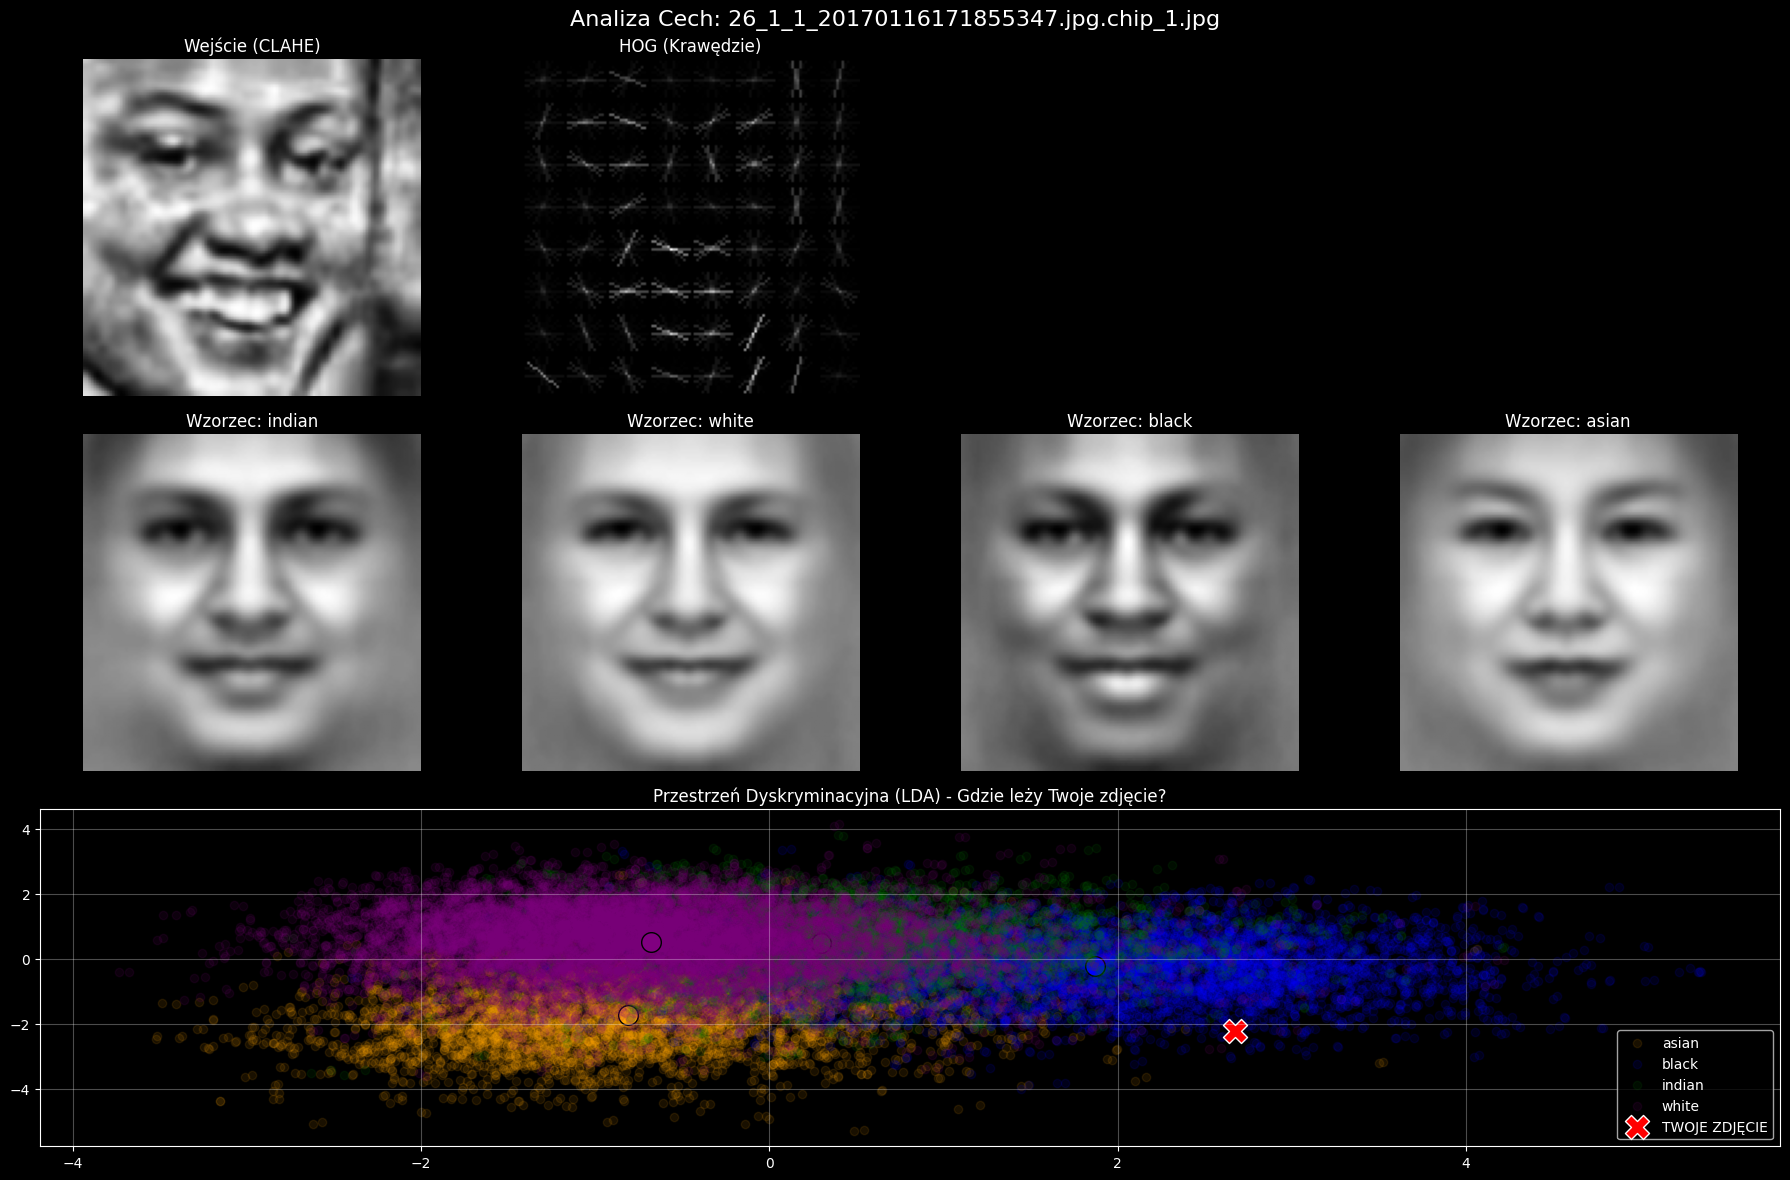

In [7]:
# A. Generowanie średnich twarzy do wizualizacji
average_faces = {}
for cls in classes:
    average_faces[cls] = create_average_face(os.path.join(train_path, cls))

def visualize_features_panel(image_path):
    # Wczytaj zdjęcie
    input_img = preprocess_image_advanced(image_path, IMG_SIZE)
    if input_img is None: return

    # Przetwórz
    flat_vec = input_img.flatten().reshape(1, -1) / 255.0
    vec_pca = pca_eigen.transform(flat_vec)
    vec_lda = lda.transform(vec_pca)[0] # X, Y w przestrzeni LDA
    _, hog_vis = hog(input_img, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    # Rysowanie
    fig = plt.figure(figsize=(18, 12))
    plt.suptitle(f"Analiza Cech: {os.path.basename(image_path)}", fontsize=16)

    # 1. Obraz i HOG
    plt.subplot(3, 4, 1); plt.imshow(input_img, cmap='gray'); plt.title("Wejście (CLAHE)"); plt.axis('off')
    plt.subplot(3, 4, 2); plt.imshow(hog_vis, cmap='gray'); plt.title("HOG (Krawędzie)"); plt.axis('off')

    # 2. Wzorce klas (Średnie twarze)
    for i, cls in enumerate(classes):
        plt.subplot(3, 4, i+5)
        plt.imshow(average_faces[cls], cmap='gray')
        plt.title(f"Wzorzec: {cls}")
        plt.axis('off')

    # 3. Mapa LDA
    ax = plt.subplot(3, 1, 3)
    colors = ['orange', 'blue', 'green', 'purple']
    for i, cls in enumerate(le.classes_):
        points = X_train_lda[y_train == i]
        ax.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.1, label=cls) # Tło
        center = np.mean(points, axis=0)
        ax.scatter(center[0], center[1], c=colors[i], s=200, edgecolors='black') # Centroid

    ax.scatter(vec_lda[0], vec_lda[1], c='red', s=300, marker='X', label='TWOJE ZDJĘCIE', edgecolors='white')
    ax.legend(); ax.set_title("Przestrzeń Dyskryminacyjna (LDA) - Gdzie leży Twoje zdjęcie?"); ax.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

# TEST WIZUALIZACJI (Losowe zdjęcie z testu)
test_root = os.path.join(DATASET_PATH, 'test')
rnd_cls = random.choice(classes)
rnd_file = random.choice(os.listdir(os.path.join(test_root, rnd_cls)))
visualize_features_panel(os.path.join(test_root, rnd_cls, rnd_file))

### 8. Fuzja Cech i Balansowanie (SMOTE)
Łączymy wszystkie wyekstrahowane informacje w jeden "Super-Wektor":
`[Cechy Fisherfaces] + [Cechy HOG (PCA)] + [Cechy Gabor]`
Następnie skalujemy dane (StandardScaler) i używamy SMOTE, aby wyrównać liczebność klas w zbiorze treningowym (syntetyczne próbki dla mniejszości).

In [8]:
print("Fuzja cech: LDA + HOG(PCA) + Gabor...")
X_train_fused = np.concatenate((X_train_lda, X_train_hog_pca, X_train_gabor), axis=1)
X_test_fused = np.concatenate((X_test_lda, X_test_hog_pca, X_test_gabor), axis=1)

# Skalowanie (Krytyczne dla MLP i KNN!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fused)
X_test_scaled = scaler.transform(X_test_fused)

print("Balansowanie danych (SMOTE)...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Dane gotowe do treningu. Kształt wejścia: {X_train_resampled.shape}")

Fuzja cech: LDA + HOG(PCA) + Gabor...
Balansowanie danych (SMOTE)...
Dane gotowe do treningu. Kształt wejścia: (56432, 490)


### 9. Trening Klasyfikatorów i Ewaluacja
Wytrenujemy dwa modele na naszych ręcznie przygotowanych cechach:
1.  **MLP (Multi-Layer Perceptron):** Klasyczna sieć neuronowa. Uczy się nieliniowych relacji między cechami Gabora, HOG i LDA. Używamy `EarlyStopping`, aby zapobiec przeuczeniu.

--- Zaawansowany Tuning MLP (GridSearch) ---
Rozpoczynanie treningu (to potrwa dłużej niż 50 sekund!)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.001, solver=adam; total time= 1.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.001, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.0001, solver=adam; total time= 2.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.0001, solver=adam; total time= 2.5min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.0001, solver=adam; total time= 2.6min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.001, solver=adam; total time= 2.8min
[CV] END activation=relu, alpha=0.0001, hidden_layer_size

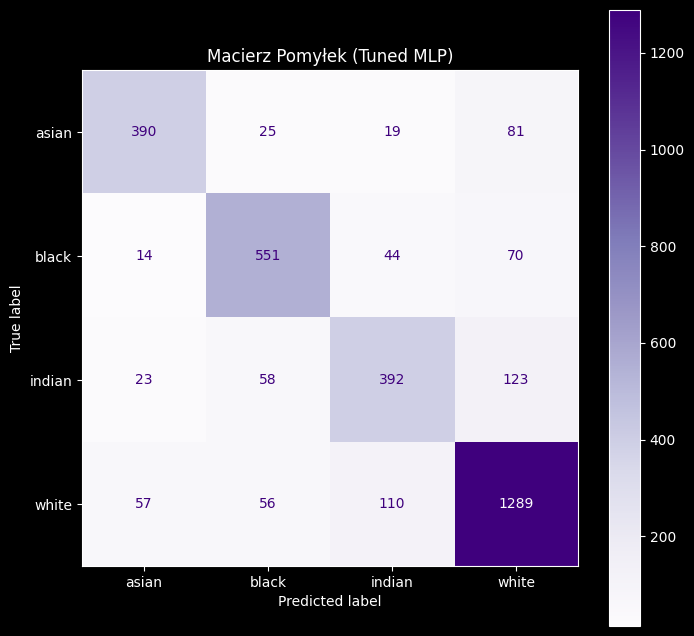

In [11]:
print("--- Zaawansowany Tuning MLP (GridSearch) ---")

# Definiujemy znacznie potężniejszą siatkę parametrów
param_grid_mlp = {
    # Architektura: Sprawdzamy głębsze i szersze sieci
    'hidden_layer_sizes': [(256, 128), (512, 256, 128), (1024, 1024, 512, 512)],

    # Regularyzacja: Alpha zapobiega przeuczeniu przy dużych sieciach
    'alpha': [0.0001, 0.001, 0.01],

    # Szybkość uczenia: Mniejsze wartości = dokładniejsze, ale wolniejsze
    'learning_rate_init': [0.001, 0.0001],

    # Silnik
    'solver': ['adam'],
    'activation': ['relu']
}

# Tworzymy model bazowy z dużą liczbą epok i cierpliwością
base_mlp = MLPClassifier(max_iter=1000,          # Dajemy jej dużo czasu
                         early_stopping=True,    # Włączamy hamulec
                         n_iter_no_change=20,    # ...ale niech będzie cierpliwy (20 epok bez poprawy)
                         random_state=42)

# Uruchamiamy szukanie
grid_mlp = GridSearchCV(base_mlp, param_grid_mlp, cv=3, n_jobs=-1, verbose=2)

print("Rozpoczynanie treningu (to potrwa dłużej niż 50 sekund!)...")
grid_mlp.fit(X_train_resampled, y_train_resampled)

print(f"\nNajlepsze parametry MLP: {grid_mlp.best_params_}")

# Ewaluacja
y_pred_mlp_tuned = grid_mlp.predict(X_test_scaled)

print("\nWyniki Ulepszonego MLP:")
print(classification_report(y_test, y_pred_mlp_tuned, target_names=le.classes_))

# Macierz pomyłek
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp_tuned, display_labels=le.classes_, cmap='Purples', ax=ax)
ax.set_title("Macierz Pomyłek (Tuned MLP)")
plt.show()